<a href="https://colab.research.google.com/github/sunweihao1997/swh_code/blob/master/XGBoost_typhoon_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌀 台风频数季节性预测模型 v2.0
## 基于XGBoost与ENSO修正的统计-动力相结合方案

---

### v2.0 更新内容
- ✅ **修复数据泄露**: StandardScaler仅在训练集上fit
- ✅ **时间序列交叉验证**: 5折滚动验证
- ✅ **自动超参数寻优**: 网格搜索最优参数
- ✅ **趋势特征**: 新增OND-JAS差值特征

## 1️⃣ 环境配置

In [4]:
# 安装必要的库
!pip install xgboost -q

# 导入所需库
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import pickle
import json
from itertools import product

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

print("✅ 环境配置完成！")
print(f"   XGBoost版本: {xgb.__version__}")

✅ 环境配置完成！
   XGBoost版本: 3.1.2


## 2️⃣ 上传数据文件

In [5]:
from google.colab import files

print("请上传以下文件:")
print("  1. typhoon_count.csv (台风数据)")
print("  2. MEI的NC文件 (需包含月度数据)")
print("  3. PDO的NC文件")
print("  4. IOD的NC文件")
print("  5. QBO的NC文件")
print("\n点击下方'选择文件'按钮上传...")

uploaded = files.upload()

print(f"\n✅ 已上传 {len(uploaded)} 个文件:")
for fname in uploaded.keys():
    print(f"   - {fname}")

请上传以下文件:
  1. typhoon_count.csv (台风数据)
  2. MEI的NC文件 (需包含月度数据)
  3. PDO的NC文件
  4. IOD的NC文件
  5. QBO的NC文件

点击下方'选择文件'按钮上传...


Saving iod_ersst_v5.nc to iod_ersst_v5.nc
Saving mei_v2.nc to mei_v2.nc
Saving pdo_ersst_v5.nc to pdo_ersst_v5.nc
Saving qbo.nc to qbo.nc
Saving typhoon_count.csv to typhoon_count.csv

✅ 已上传 5 个文件:
   - iod_ersst_v5.nc
   - mei_v2.nc
   - pdo_ersst_v5.nc
   - qbo.nc
   - typhoon_count.csv


## 3️⃣ 检查NC文件结构

In [6]:
# 列出当前目录的文件
print("当前目录文件:")
for f in os.listdir('.'):
    if f.endswith('.nc') or f.endswith('.csv'):
        print(f"  {f}")

print("\n" + "="*50)

# 检查每个NC文件的结构
nc_files = [f for f in os.listdir('.') if f.endswith('.nc')]

for nc_file in nc_files:
    print(f"\n📄 {nc_file}:")
    try:
        ds = xr.open_dataset(nc_file)
        print(f"   维度: {dict(ds.dims)}")
        print(f"   数据变量: {list(ds.data_vars)}")
        print(f"   坐标: {list(ds.coords)}")

        if 'time' in ds.coords:
            time_range = pd.to_datetime(ds['time'].values)
            print(f"   时间范围: {time_range.min().year} - {time_range.max().year}")
            print(f"   时间步数: {len(time_range)} (应为月度数据)")
        ds.close()
    except Exception as e:
        print(f"   ❌ 读取失败: {e}")

当前目录文件:
  iod_ersst_v5.nc
  typhoon_count.csv
  pdo_ersst_v5.nc
  mei_v2.nc
  qbo.nc


📄 iod_ersst_v5.nc:
   维度: {'time': 2063}
   数据变量: ['iod']
   坐标: ['time']
   时间范围: 1854 - 2025
   时间步数: 2063 (应为月度数据)

📄 pdo_ersst_v5.nc:
   维度: {'time': 2064}
   数据变量: ['pdo']
   坐标: ['time']
   时间范围: 1854 - 2025
   时间步数: 2064 (应为月度数据)

📄 mei_v2.nc:
   维度: {'time': 564}
   数据变量: ['mei']
   坐标: ['time']
   时间范围: 1979 - 2025
   时间步数: 564 (应为月度数据)

📄 qbo.nc:
   维度: {'time': 935}
   数据变量: ['value']
   坐标: ['time']
   时间范围: 1948 - 2025
   时间步数: 935 (应为月度数据)


## 4️⃣ 配置参数 ⚠️ 请根据上一步的输出修改

In [15]:
class Config:
    """
    配置类 v2.0 - 请根据您的实际数据文件修改
    """

    # ----- 数据文件路径 -----
    TYPHOON_DATA_PATH = 'typhoon_count.csv'
    MEI_NC_PATH = 'mei_v2.nc'      # ← 修改为您的MEI文件名
    PDO_NC_PATH = 'pdo_ersst_v5.nc'      # ← 修改为您的PDO文件名
    IOD_NC_PATH = 'iod_ersst_v5.nc'      # ← 修改为您的IOD文件名
    QBO_NC_PATH = 'qbo.nc'      # ← 修改为您的QBO文件名

    # ----- NC文件变量名 -----
    MEI_VAR_NAME = 'mei'        # ← 修改为实际变量名
    PDO_VAR_NAME = 'pdo'        # ← 修改为实际变量名
    IOD_VAR_NAME = 'iod'        # ← 修改为实际变量名
    QBO_VAR_NAME = 'value'        # ← 修改为实际变量名
    TIME_VAR_NAME = 'time'

    # ----- 模型参数 -----
    START_YEAR = 1980
    END_YEAR = 2024
    PREDICT_YEAR = 2025
    TEST_SPLIT_YEAR = 2015

    # ----- 时间序列交叉验证 -----
    CV_N_SPLITS = 5  # 交叉验证折数

    # ----- 超参数搜索空间 -----
    PARAM_GRID = {
        'max_depth': [1, 2, 3, 4, 5, 6],
        'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
        'n_estimators': [50, 100, 150, 300, 500, 800, 1000],
        'min_child_weight': [1, 3, 5],
    }

    # ----- XGBoost固定参数 -----
    XGB_FIXED_PARAMS = {
        'objective': 'count:poisson',
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': 42,
        'verbosity': 0
    }

    # ----- 海区列表 -----
    REGIONS = ['South China Sea', 'Eastern China Sea', 'Japan Sea', 'Yellow Sea']

    # ----- 特征工程 -----
    USE_TREND_FEATURES = True  # 是否使用趋势特征 (OND-JAS)

    # ----- 输出配置 -----
    OUTPUT_DIR = 'model_outputs'
    SAVE_MODEL = True

print("✅ 配置已加载！")
print(f"   训练年份: {Config.START_YEAR} - {Config.END_YEAR}")
print(f"   交叉验证: {Config.CV_N_SPLITS}折")
print(f"   趋势特征: {'启用' if Config.USE_TREND_FEATURES else '禁用'}")
print(f"   超参数组合数: {np.prod([len(v) for v in Config.PARAM_GRID.values()])}")

✅ 配置已加载！
   训练年份: 1980 - 2024
   交叉验证: 5折
   趋势特征: 启用
   超参数组合数: 630


## 5️⃣ 数据加载模块

In [16]:
class DataLoader:
    """数据加载器类 v2.0 - 支持趋势特征"""

    def __init__(self, config):
        self.config = config
        self.typhoon_data = None
        self.climate_indices = None

    def load_typhoon_data(self):
        print("\n[1/5] 加载台风数据...")
        df = pd.read_csv(self.config.TYPHOON_DATA_PATH)
        print(f"    ✓ 成功加载: {len(df)} 条记录")
        print(f"    ✓ 时间范围: {df['Year'].min()} - {df['Year'].max()}")
        self.typhoon_data = df
        return df

    def load_climate_index_from_nc(self, nc_path, var_name, index_name):
        try:
            ds = xr.open_dataset(nc_path)

            if var_name in ds.data_vars:
                data = ds[var_name]
            else:
                available_vars = list(ds.data_vars)
                print(f"    ! 警告: 未找到'{var_name}', 可用: {available_vars}")
                if len(available_vars) == 1:
                    var_name = available_vars[0]
                    data = ds[var_name]
                else:
                    raise ValueError(f"请指定正确的变量名")

            df = data.to_dataframe().reset_index()

            time_col = self.config.TIME_VAR_NAME
            if time_col not in df.columns:
                for col in df.columns:
                    if 'time' in col.lower():
                        time_col = col
                        break

            df['year'] = pd.to_datetime(df[time_col]).dt.year
            df['month'] = pd.to_datetime(df[time_col]).dt.month
            df['value'] = df[var_name]

            result = df[['year', 'month', 'value']].copy()
            ds.close()
            return result

        except Exception as e:
            print(f"    ! 加载{index_name}失败: {e}")
            return None

    def load_all_climate_indices(self):
        print("\n[2/5] 加载气候指数...")
        indices = {}

        for name, path, var in [
            ('MEI', self.config.MEI_NC_PATH, self.config.MEI_VAR_NAME),
            ('PDO', self.config.PDO_NC_PATH, self.config.PDO_VAR_NAME),
            ('IOD', self.config.IOD_NC_PATH, self.config.IOD_VAR_NAME),
            ('QBO', self.config.QBO_NC_PATH, self.config.QBO_VAR_NAME)
        ]:
            print(f"    加载{name}...")
            data = self.load_climate_index_from_nc(path, var, name)
            if data is not None:
                indices[name] = data
                print(f"    ✓ {name}: {data['year'].min()}-{data['year'].max()}")

        self.climate_indices = indices
        return indices

    def calculate_seasonal_average(self, index_data, year, months):
        mask = (index_data['year'] == year) & (index_data['month'].isin(months))
        values = index_data.loc[mask, 'value']
        return values.mean() if len(values) >= 2 else np.nan

    def build_feature_matrix(self):
        print("\n[3/5] 构建特征矩阵...")

        years = sorted(self.typhoon_data['Year'].unique())
        years = [y for y in years if self.config.START_YEAR <= y <= self.config.END_YEAR]

        feature_records = []
        for year in years:
            record = {'Year': year}
            prev_year = year - 1

            for index_name, index_data in self.climate_indices.items():
                # 基础特征: OND均值
                ond_avg = self.calculate_seasonal_average(index_data, prev_year, [10, 11, 12])
                record[f'{index_name}_OND'] = ond_avg

                # 趋势特征: OND - JAS
                if self.config.USE_TREND_FEATURES:
                    jas_avg = self.calculate_seasonal_average(index_data, prev_year, [7, 8, 9])
                    if not np.isnan(ond_avg) and not np.isnan(jas_avg):
                        record[f'{index_name}_TREND'] = ond_avg - jas_avg
                    else:
                        record[f'{index_name}_TREND'] = np.nan

            # 当年JASO MEI (用于ENSO修正)
            if 'MEI' in self.climate_indices:
                jaso_avg = self.calculate_seasonal_average(self.climate_indices['MEI'], year, [7, 8, 9, 10])
                record['MEI_Current_JASO'] = jaso_avg

            feature_records.append(record)

        feature_df = pd.DataFrame(feature_records)

        # 合并台风数据
        typhoon_pivot = self.typhoon_data.pivot_table(
            index='Year', columns='Region', values='Typhoon_Count', aggfunc='sum'
        ).reset_index()

        for col in typhoon_pivot.columns:
            if col != 'Year':
                typhoon_pivot = typhoon_pivot.rename(columns={col: f'Target_{col}'})

        result = feature_df.merge(typhoon_pivot, on='Year', how='left')
        result = result.dropna()

        ond_features = [c for c in result.columns if '_OND' in c]
        trend_features = [c for c in result.columns if '_TREND' in c]

        print(f"    ✓ 样本数: {len(result)}")
        print(f"    ✓ 基础特征: {ond_features}")
        if self.config.USE_TREND_FEATURES:
            print(f"    ✓ 趋势特征: {trend_features}")

        return result

print("✅ 数据加载模块已定义！")

✅ 数据加载模块已定义！


## 6️⃣ 模型训练模块 (v2.0 修复版)

In [17]:
class TyphoonPredictionModel:
    """
    台风预测模型 v2.0
    - 修复数据泄露
    - 时间序列交叉验证
    - 自动超参数寻优
    """

    def __init__(self, config):
        self.config = config
        self.models = {}
        self.scalers = {}
        self.correction_params = {}
        self.feature_importance = {}
        self.training_history = {}
        self.best_params = {}
        self.cv_results = {}

    def time_series_cross_validate(self, X, y, params, n_splits=5):
        """时间序列交叉验证"""
        tscv = TimeSeriesSplit(n_splits=n_splits)
        fold_rmses = []

        for train_idx, val_idx in tscv.split(X):
            X_train_cv, X_val_cv = X[train_idx], X[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]

            # 【关键】仅在训练折上fit scaler
            scaler_cv = StandardScaler()
            X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
            X_val_cv_scaled = scaler_cv.transform(X_val_cv)

            model_cv = xgb.XGBRegressor(**params)
            model_cv.fit(X_train_cv_scaled, y_train_cv, verbose=False)

            y_pred_cv = model_cv.predict(X_val_cv_scaled)
            rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
            fold_rmses.append(rmse)

        return np.mean(fold_rmses), np.std(fold_rmses), fold_rmses

    def grid_search_params(self, X, y, region_name):
        """网格搜索最优超参数"""
        print(f"        正在搜索最优参数...")

        param_grid = self.config.PARAM_GRID
        fixed_params = self.config.XGB_FIXED_PARAMS.copy()

        best_rmse = float('inf')
        best_params = None

        param_names = list(param_grid.keys())
        param_values = list(param_grid.values())
        total = np.prod([len(v) for v in param_values])

        for values in product(*param_values):
            current_params = fixed_params.copy()
            for name, value in zip(param_names, values):
                current_params[name] = value

            mean_rmse, _, _ = self.time_series_cross_validate(
                X, y, current_params, n_splits=self.config.CV_N_SPLITS
            )

            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_params = current_params.copy()

        print(f"        ✓ 最优: depth={best_params['max_depth']}, lr={best_params['learning_rate']}, n={best_params['n_estimators']}")

        return best_params, best_rmse

    def train_single_region(self, data, region, feature_cols):
        """训练单个海区模型 (修复数据泄露)"""
        target_col = f'Target_{region}'
        if target_col not in data.columns:
            return None

        X = data[feature_cols].values
        y = data[target_col].values
        years = data['Year'].values

        # 切分数据
        train_mask = years < self.config.TEST_SPLIT_YEAR
        test_mask = years >= self.config.TEST_SPLIT_YEAR

        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        years_train, years_test = years[train_mask], years[test_mask]

        # 【关键修复】仅在训练集上fit StandardScaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scalers[region] = scaler

        # 超参数搜索
        best_params, cv_rmse = self.grid_search_params(X_train, y_train, region)
        self.best_params[region] = best_params

        # 训练最终模型
        model = xgb.XGBRegressor(**best_params)
        model.fit(X_train_scaled, y_train, verbose=False)
        self.models[region] = model

        # 预测
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        # CV结果
        _, _, fold_rmses = self.time_series_cross_validate(
            X_train, y_train, best_params, n_splits=self.config.CV_N_SPLITS
        )
        self.cv_results[region] = {
            'mean_rmse': np.mean(fold_rmses),
            'std_rmse': np.std(fold_rmses),
            'fold_rmses': fold_rmses
        }

        # 特征重要性
        self.feature_importance[region] = dict(zip(feature_cols, model.feature_importances_))

        # ENSO修正
        if 'MEI_Current_JASO' in data.columns:
            mei_current = data.loc[train_mask, 'MEI_Current_JASO'].values
            residuals = y_train - y_train_pred
            valid_mask = ~np.isnan(mei_current)
            if valid_mask.sum() > 5:
                slope, intercept = np.polyfit(mei_current[valid_mask], residuals[valid_mask], 1)
                self.correction_params[region] = {'slope': slope, 'intercept': intercept}

        result = {
            'region': region,
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'cv_rmse': cv_rmse,
            'test_r2': r2_score(y_test, y_test_pred),
            'y_train': y_train, 'y_train_pred': y_train_pred,
            'y_test': y_test, 'y_test_pred': y_test_pred,
            'years_train': years_train, 'years_test': years_test,
        }
        self.training_history[region] = result
        return result

    def train_all_regions(self, data):
        print("\n[4/5] 训练XGBoost模型 (含超参数寻优)...")
        feature_cols = [c for c in data.columns if '_OND' in c or '_TREND' in c]
        print(f"    特征: {feature_cols}")

        for region in self.config.REGIONS:
            print(f"\n    ===== {region} =====")
            result = self.train_single_region(data, region, feature_cols)
            if result:
                print(f"        Train RMSE: {result['train_rmse']:.2f}")
                print(f"        Test RMSE: {result['test_rmse']:.2f}")
                print(f"        CV RMSE: {result['cv_rmse']:.2f} ± {self.cv_results[region]['std_rmse']:.2f}")

    def predict(self, features_dict, enso_forecast=None):
        feature_cols = sorted([c for c in features_dict.keys() if '_OND' in c or '_TREND' in c])
        X = np.array([[features_dict[c] for c in feature_cols]])

        predictions = {}
        for region, model in self.models.items():
            X_scaled = self.scalers[region].transform(X)
            base_pred = model.predict(X_scaled)[0]

            correction = 0
            if enso_forecast is not None and region in self.correction_params:
                p = self.correction_params[region]
                correction = p['slope'] * enso_forecast + p['intercept']

            final_pred = max(0, base_pred + correction)
            predictions[region] = {
                'base': base_pred,
                'correction': correction,
                'final': final_pred,
                'rounded': round(final_pred)
            }
        return predictions

    def get_model_summary(self):
        summary = []
        for region in self.models.keys():
            info = {
                'Region': region,
                'max_depth': self.best_params[region]['max_depth'],
                'lr': self.best_params[region]['learning_rate'],
                'CV_RMSE': f"{self.cv_results[region]['mean_rmse']:.2f}±{self.cv_results[region]['std_rmse']:.2f}",
                'Test_RMSE': f"{self.training_history[region]['test_rmse']:.2f}",
            }
            summary.append(info)
        return pd.DataFrame(summary)

print("✅ 模型训练模块已定义！(v2.0 修复版)")

✅ 模型训练模块已定义！(v2.0 修复版)


## 7️⃣ 运行模型训练

In [18]:
# 创建输出目录
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

# 加载数据
loader = DataLoader(Config)
typhoon_data = loader.load_typhoon_data()
climate_indices = loader.load_all_climate_indices()
feature_matrix = loader.build_feature_matrix()

# 显示特征矩阵
print("\n" + "="*50)
print("特征矩阵预览:")
display(feature_matrix.head())


[1/5] 加载台风数据...
    ✓ 成功加载: 463 条记录
    ✓ 时间范围: 1884 - 2025

[2/5] 加载气候指数...
    加载MEI...
    ✓ MEI: 1979-2025
    加载PDO...
    ✓ PDO: 1854-2025
    加载IOD...
    ✓ IOD: 1854-2025
    加载QBO...
    ✓ QBO: 1948-2025

[3/5] 构建特征矩阵...
    ✓ 样本数: 37
    ✓ 基础特征: ['MEI_OND', 'PDO_OND', 'IOD_OND', 'QBO_OND']
    ✓ 趋势特征: ['MEI_TREND', 'PDO_TREND', 'IOD_TREND', 'QBO_TREND']

特征矩阵预览:


,Year,MEI_OND,MEI_TREND,PDO_OND,PDO_TREND,IOD_OND,IOD_TREND,QBO_OND,QBO_TREND,MEI_Current_JASO,Target_Eastern China Sea,Target_Japan Sea,Target_South China Sea,Target_Yellow Sea
0,1980,0.463333,0.213333,0.580000,0.170000,-0.316667,-0.183333,-20.836668,1.233334,0.1625,5.0,3.0,18.0,2.0
1,1981,-0.056667,-0.263333,0.666667,0.753333,-0.130000,0.030000,11.660000,1.320001,-0.2875,7.0,7.0,14.0,4.0
2,1982,-0.210000,0.120000,0.346667,-0.053333,-0.270000,0.183333,-10.486667,-3.136667,1.7525,1.0,4.0,11.0,1.0
4,1984,-0.500000,-0.486667,1.196667,-0.176667,0.000000,-0.500000,-10.610000,-4.723333,-0.2175,7.0,4.0,14.0,5.0
5,1985,-0.353333,-0.126667,0.483333,0.536667,-0.253333,0.086667,-14.313333,11.930001,-0.3075,11.0,4.0,16.0,5.0


In [19]:
# 训练模型（含超参数搜索，可能需要几分钟）
print("⏳ 开始训练，包含超参数搜索，请稍候...")
print(f"   共 {np.prod([len(v) for v in Config.PARAM_GRID.values()])} 种参数组合 × {len(Config.REGIONS)} 个海区")

model = TyphoonPredictionModel(Config)
model.train_all_regions(feature_matrix)

print("\n" + "="*50)
print("✅ 模型训练完成！")
print("="*50)
print("\n模型摘要:")
display(model.get_model_summary())

⏳ 开始训练，包含超参数搜索，请稍候...
   共 630 种参数组合 × 4 个海区

[4/5] 训练XGBoost模型 (含超参数寻优)...
    特征: ['MEI_OND', 'MEI_TREND', 'PDO_OND', 'PDO_TREND', 'IOD_OND', 'IOD_TREND', 'QBO_OND', 'QBO_TREND']

    ===== South China Sea =====
        正在搜索最优参数...
        ✓ 最优: depth=1, lr=0.05, n=50
        Train RMSE: 2.01
        Test RMSE: 3.58
        CV RMSE: 2.66 ± 0.83

    ===== Eastern China Sea =====
        正在搜索最优参数...
        ✓ 最优: depth=6, lr=0.01, n=50
        Train RMSE: 2.33
        Test RMSE: 2.95
        CV RMSE: 2.62 ± 0.63

    ===== Japan Sea =====
        正在搜索最优参数...
        ✓ 最优: depth=1, lr=0.01, n=50
        Train RMSE: 1.58
        Test RMSE: 1.16
        CV RMSE: 1.75 ± 0.65

    ===== Yellow Sea =====
        正在搜索最优参数...
        ✓ 最优: depth=1, lr=0.01, n=50
        Train RMSE: 1.55
        Test RMSE: 1.42
        CV RMSE: 1.48 ± 0.72

✅ 模型训练完成！

模型摘要:


,Region,max_depth,lr,CV_RMSE,Test_RMSE
0,South China Sea,1,0.05,2.66±0.83,3.58
1,Eastern China Sea,6,0.01,2.62±0.63,2.95
2,Japan Sea,1,0.01,1.75±0.65,1.16
3,Yellow Sea,1,0.01,1.48±0.72,1.42


## 8️⃣ 结果可视化

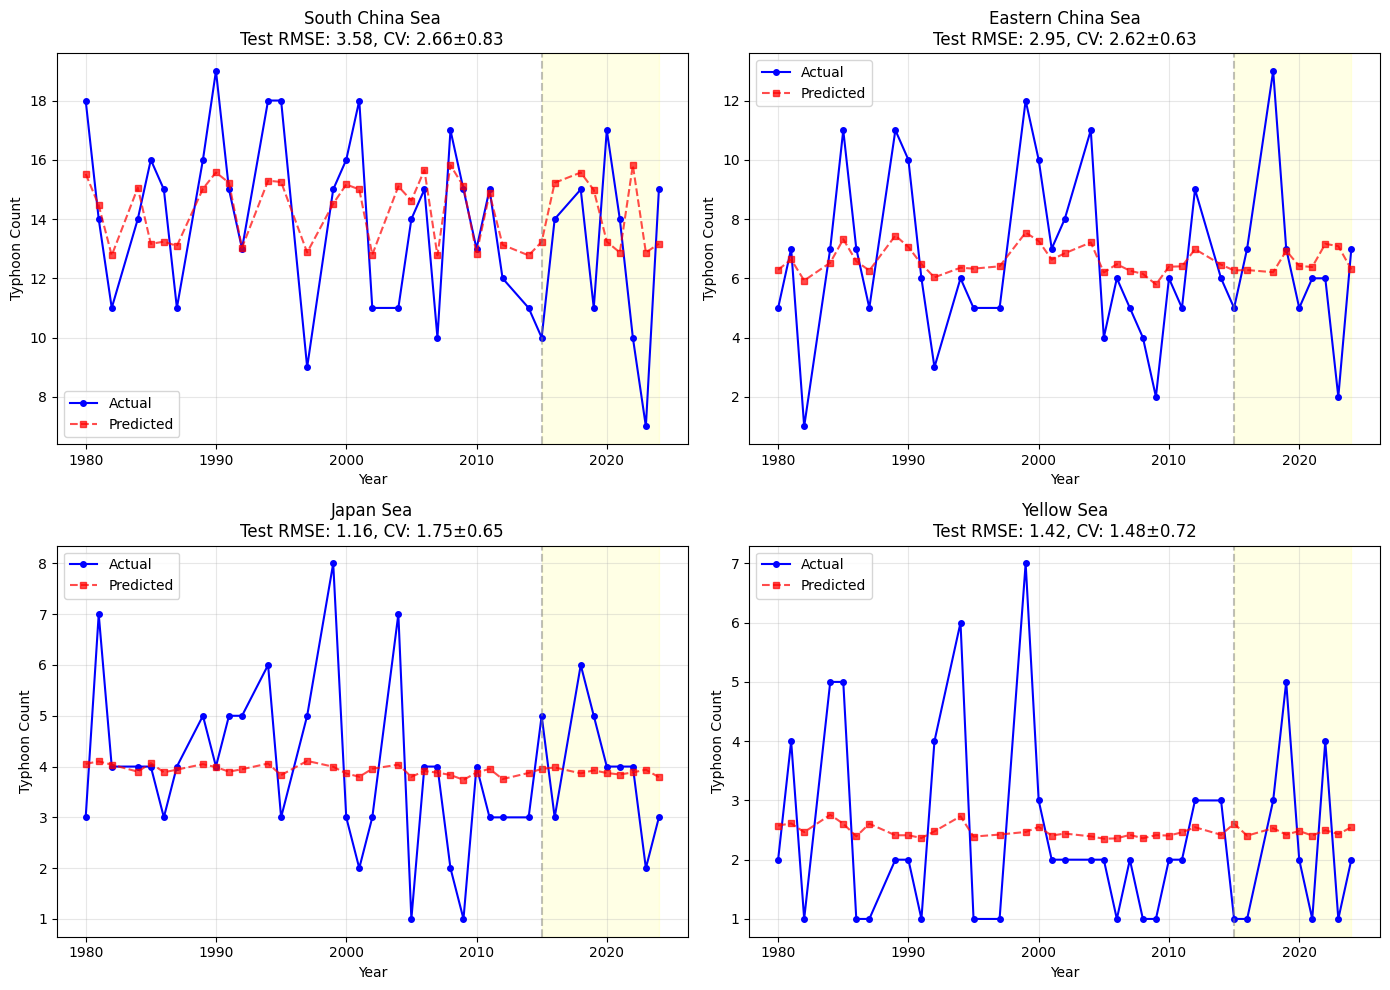

In [20]:
# 绘制预测vs实际对比图
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (region, result) in enumerate(model.training_history.items()):
    if idx >= 4:
        break
    ax = axes[idx]

    all_years = np.concatenate([result['years_train'], result['years_test']])
    all_actual = np.concatenate([result['y_train'], result['y_test']])
    all_pred = np.concatenate([result['y_train_pred'], result['y_test_pred']])

    ax.plot(all_years, all_actual, 'b-o', label='Actual', markersize=4)
    ax.plot(all_years, all_pred, 'r--s', label='Predicted', markersize=4, alpha=0.7)

    ax.axvline(x=Config.TEST_SPLIT_YEAR, color='gray', linestyle='--', alpha=0.5)
    ax.axvspan(Config.TEST_SPLIT_YEAR, all_years.max(), alpha=0.1, color='yellow')

    cv_info = model.cv_results[region]
    ax.set_title(f'{region}\nTest RMSE: {result["test_rmse"]:.2f}, CV: {cv_info["mean_rmse"]:.2f}±{cv_info["std_rmse"]:.2f}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Typhoon Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/prediction_vs_actual.png', dpi=150)
plt.show()

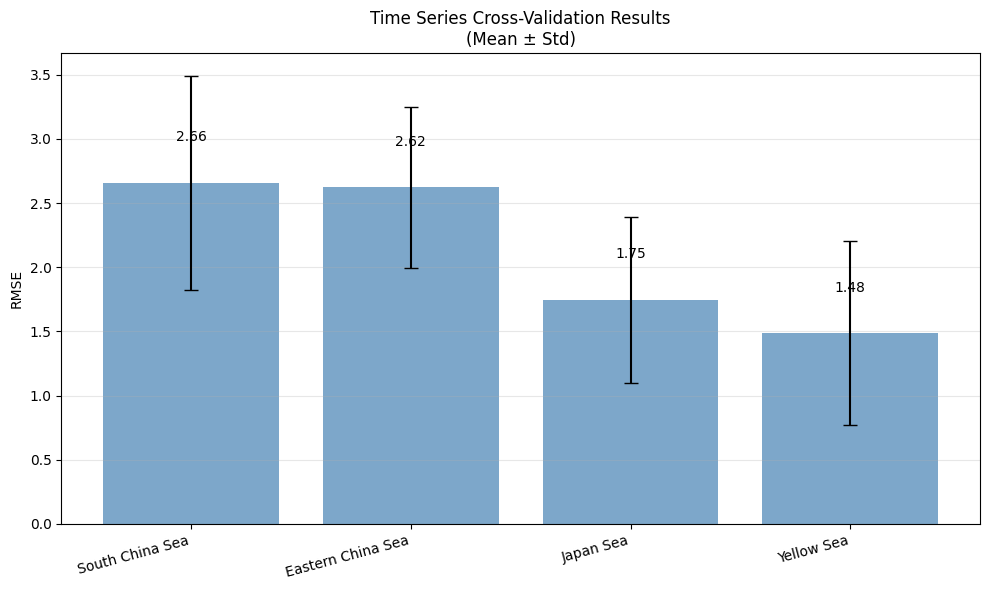

In [21]:
# 绘制交叉验证结果图
fig, ax = plt.subplots(figsize=(10, 6))

regions = list(model.cv_results.keys())
means = [model.cv_results[r]['mean_rmse'] for r in regions]
stds = [model.cv_results[r]['std_rmse'] for r in regions]

x = np.arange(len(regions))
bars = ax.bar(x, means, yerr=stds, capsize=5, color='steelblue', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=15, ha='right')
ax.set_ylabel('RMSE')
ax.set_title('Time Series Cross-Validation Results\n(Mean ± Std)')
ax.grid(True, alpha=0.3, axis='y')

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
           f'{mean:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/cv_results.png', dpi=150)
plt.show()

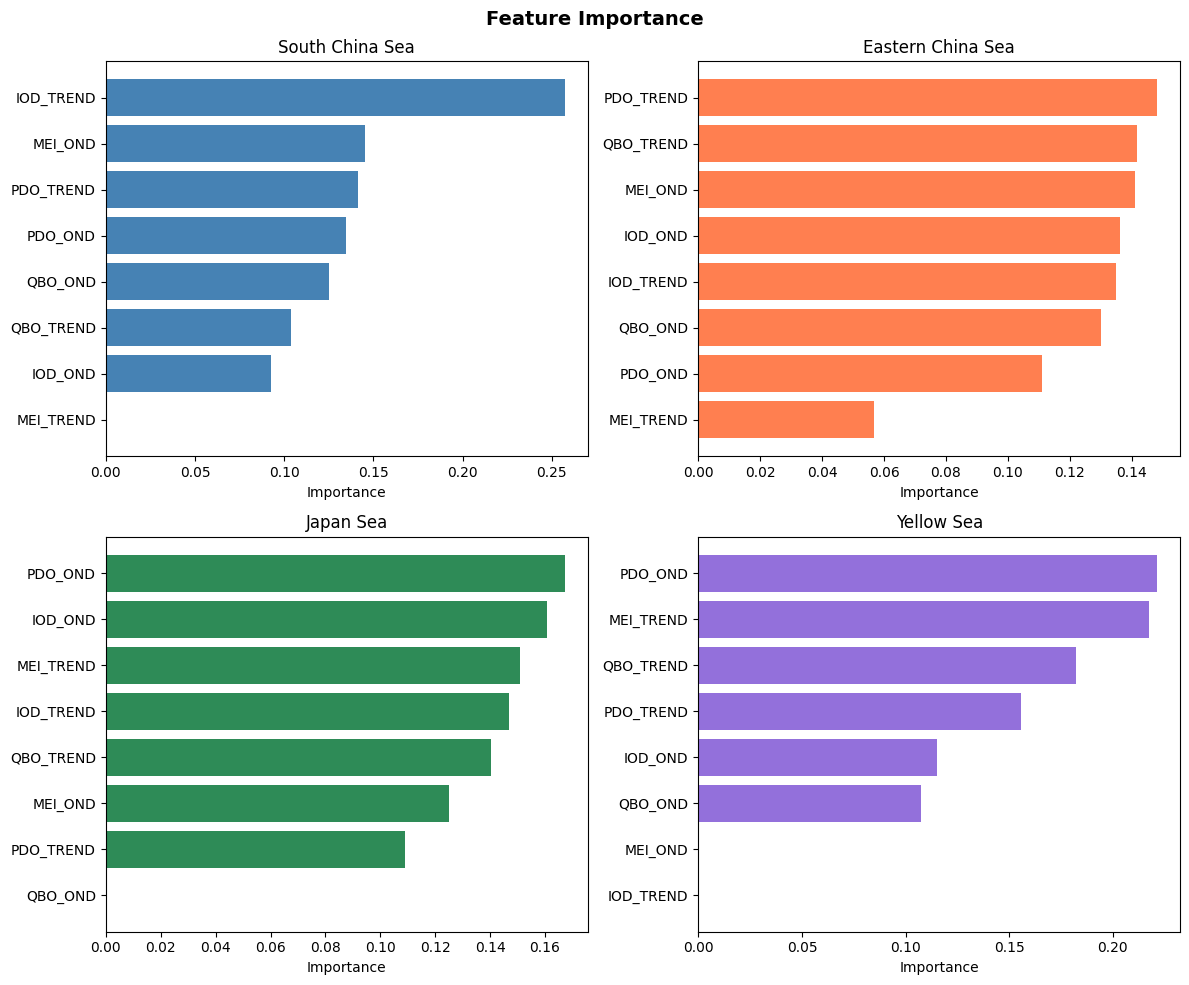

In [14]:
# 绘制特征重要性图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
colors = ['steelblue', 'coral', 'seagreen', 'mediumpurple']

for idx, (region, importance) in enumerate(model.feature_importance.items()):
    if idx >= 4:
        break
    ax = axes[idx]

    sorted_imp = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True))
    ax.barh(list(sorted_imp.keys()), list(sorted_imp.values()), color=colors[idx])
    ax.set_xlabel('Importance')
    ax.set_title(region)
    ax.invert_yaxis()

plt.suptitle('Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/feature_importance.png', dpi=150)
plt.show()